In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load combined train set
with np.load(
    "/Users/Ingo/Python Files/Capstone Project/preprocessed_dfs/train_set_preprocessed.npz") as npz_file:
    X_tr_np = npz_file["features"]
    y_tr = npz_file["labels"]
    
# load combined val set
with np.load(
    "/Users/Ingo/Python Files/Capstone Project/preprocessed_dfs/val_set_preprocessed.npz") as npz_file:
    X_val_np = npz_file["features"]
    y_val = npz_file["labels"]
    
# load combined test set
with np.load(
    "/Users/Ingo/Python Files/Capstone Project/preprocessed_dfs/test_set_preprocessed.npz") as npz_file:
    X_te_np = npz_file["features"]
    y_te = npz_file["labels"]

In [3]:
# load B term train set
with np.load(
    "/Users/Ingo/Python Files/Capstone Project/preprocessed_dfs/train_set_preprocessed_b.npz") as npz_file:
    X_tr_b_np = npz_file["features"]
    y_tr_b = npz_file["labels"]
    
# load B term val set
with np.load(
    "/Users/Ingo/Python Files/Capstone Project/preprocessed_dfs/val_set_preprocessed_b.npz") as npz_file:
    X_val_b_np = npz_file["features"]
    y_val_b = npz_file["labels"]
    
# load B term test set
with np.load(
    "/Users/Ingo/Python Files/Capstone Project/preprocessed_dfs/test_set_preprocessed_b.npz") as npz_file:
    X_te_b_np = npz_file["features"]
    y_te_b = npz_file["labels"]

In [4]:
# load J term train set
with np.load(
    "/Users/Ingo/Python Files/Capstone Project/preprocessed_dfs/train_set_preprocessed_j.npz") as npz_file:
    X_tr_j_np = npz_file["features"]
    y_tr_j = npz_file["labels"]
    
# load J term val set
with np.load(
    "/Users/Ingo/Python Files/Capstone Project/preprocessed_dfs/val_set_preprocessed_j.npz") as npz_file:
    X_val_j_np = npz_file["features"]
    y_val_j = npz_file["labels"]
    
# load J term test set
with np.load(
    "/Users/Ingo/Python Files/Capstone Project/preprocessed_dfs/test_set_preprocessed_j.npz") as npz_file:
    X_te_j_np = npz_file["features"]
    y_te_j = npz_file["labels"]

In [5]:
# convert all matrices to sparse format to use in models
from scipy.sparse import lil_matrix

X_tr = lil_matrix(X_tr_np, dtype = np.float32).tocsr()
X_val = lil_matrix(X_val_np, dtype = np.float32).tocsr()
X_te = lil_matrix(X_te_np, dtype = np.float32).tocsr()

X_tr_b = lil_matrix(X_tr_b_np, dtype = np.float32).tocsr()
X_val_b = lil_matrix(X_val_b_np, dtype = np.float32).tocsr()
X_te_b = lil_matrix(X_te_b_np, dtype = np.float32).tocsr()

X_tr_j = lil_matrix(X_tr_j_np, dtype = np.float32).tocsr()
X_val_j = lil_matrix(X_val_j_np, dtype = np.float32).tocsr()
X_te_j = lil_matrix(X_te_j_np, dtype = np.float32).tocsr()

### Decision Tree Classifier
We will now build a simple decision tree classifier using Gini impurity. The first goal is to find the best `max_depth` parameter.

In [6]:
from sklearn.preprocessing import MaxAbsScaler
# separately scale val and test set, as wel as B and J term sets, needed for dimensionality reducation later
scaler = MaxAbsScaler()

X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)
X_te_scaled = scaler.transform(X_te)

# B term
X_tr_scaled_b = scaler.fit_transform(X_tr_b)
X_val_scaled_b = scaler.transform(X_val_b)
X_te_scaled_b = scaler.transform(X_te_b)

# J term
X_tr_scaled_j = scaler.fit_transform(X_tr_j)
X_val_scaled_j = scaler.transform(X_val_j)
X_te_scaled_j = scaler.transform(X_te_j)

In [7]:
from sklearn.tree import DecisionTreeClassifier

# create object
test_dt = DecisionTreeClassifier(criterion = "gini", max_depth = None)

# fit estimator with training data
test_dt.fit(X_tr_scaled, y_tr)

print("maximum possible depth of decision tree:", test_dt.tree_.max_depth)

maximum possible depth of decision tree: 52


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid

# create pipeline 
pipe_dt = Pipeline([
    ("scaler", MaxAbsScaler()),
    ("dt", DecisionTreeClassifier(criterion = "gini", random_state = 0))])

# create grid with max_depth parameters to test
grid_dt = ParameterGrid({
    "dt__max_depth": np.arange(1, 50, 3)}) # 1 to 50 in steps of 3, ends therefore at 49

# get length of grid
print("length of max_depth parameters to test:", len(grid_dt))

length of max_depth parameters to test: 17


In [9]:
# combined model
# loop through all combinations

# save results
dt_results = []

for param_max_depth in grid_dt:
    pipe_dt.set_params(**param_max_depth)
    
    # fit pipe
    pipe_dt.fit(X_tr, y_tr)
    
    # calculate accuracy
    val_acc = pipe_dt.score(X_val, y_val)
    train_acc = pipe_dt.score(X_tr, y_tr)
    
    # append accuracy to param_max_depth
    param_max_depth["val_acc"] = val_acc
    param_max_depth["train_acc"] = train_acc
    
    # append param_max_depth to dt_results
    dt_results.append(param_max_depth)
    
# transform list to DataFrame
dt_results = pd.DataFrame(dt_results)
dt_results.sort_values(by = "val_acc", ascending = False)[:10]

,dt__max_depth,train_acc,val_acc
2,7,0.663123,0.629080
1,4,0.640963,0.628525
3,10,0.703643,0.628259
4,13,0.767515,0.607305
0,1,0.612595,0.597914
5,16,0.838255,0.586303
6,19,0.899945,0.556851
7,22,0.943665,0.541787
8,25,0.973085,0.523392
9,28,0.988177,0.521316


As we can already see in these 10 values, train accuracy reaches ~99% with a `max_depth = 28` while validation accuracy is at 52%. Because validation accuracy is at 62% with `max_depth = 7`, accuracy actually has to drop at one point while `max_depth` increases. To really see how the accuracy changes along with `max_depth`, we need to visualize the results.

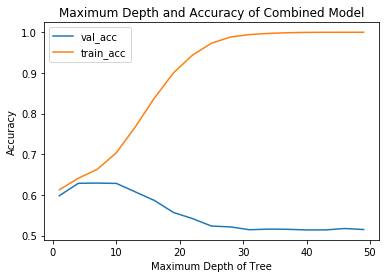

In [10]:
# visualize results
plt.plot(dt_results["dt__max_depth"], dt_results["val_acc"], label = "val_acc")
plt.plot(dt_results["dt__max_depth"], dt_results["train_acc"], label = "train_acc")
plt.xlabel("Maximum Depth of Tree")
plt.ylabel("Accuracy")
plt.title("Maximum Depth and Accuracy of Combined Model")
plt.legend()
plt.show()

The simple decision tree model is consistently overfitting, even at `max_depth = 1`. The valdation score plateaus at around `max_depth = 5` until roughly `max_depth = 10`. At that depth, the validation accuracy starts to drop again to ~52% accuracy and stays at that level. Meanwhile, the train accuracy rises up to around 99%, which means that we have a strongly overfitting model. The higher train accuracy gets, the worse the model generalizes, i.e. a case of low bias but extremely high variance.

In [11]:
# build ranked results df
dt_results_ranked = dt_results.copy()
dt_results_ranked["diff"] = dt_results["train_acc"] - dt_results["val_acc"]
dt_results_ranked.sort_values(["diff", "val_acc"], ascending = [True, False])[:5]

,dt__max_depth,train_acc,val_acc,diff
1,4,0.640963,0.628525,0.012438
0,1,0.612595,0.597914,0.014681
2,7,0.663123,0.629080,0.034043
3,10,0.703643,0.628259,0.075385
4,13,0.767515,0.607305,0.160211


In this case, I will take `max_depth = 4` because validation accuracy is almost equal to `max_depth = 7` but overfitting is only at 1.2% instead of 3.4%.

In this combined model, we thus reach a validation accuracy of 62.85%.

In [12]:
# B term
# loop through all combinations

# save results
dt_results_b = []

for param_max_depth in grid_dt:
    pipe_dt.set_params(**param_max_depth)
    
    # fit pipe
    pipe_dt.fit(X_tr_b, y_tr_b)
    
    # calculate accuracy
    val_acc = pipe_dt.score(X_val_b, y_val_b)
    train_acc = pipe_dt.score(X_tr_b, y_tr_b)
    
    # append accuracy to param_max_depth
    param_max_depth["val_acc"] = val_acc
    param_max_depth["train_acc"] = train_acc
    
    # append param_max_depth to dt_results
    dt_results_b.append(param_max_depth)
    
# transform list to DataFrame
dt_results_b = pd.DataFrame(dt_results_b)
dt_results_b.sort_values(by = "val_acc", ascending = False)[:10]

,dt__max_depth,train_acc,val_acc
2,7,0.677232,0.640736
1,4,0.632893,0.638461
3,10,0.740964,0.620394
0,1,0.622892,0.616364
4,13,0.829484,0.601092
5,16,0.902156,0.574186
6,19,0.950017,0.547020
7,22,0.974670,0.535452
13,40,1.000000,0.527263
15,46,1.000000,0.527263


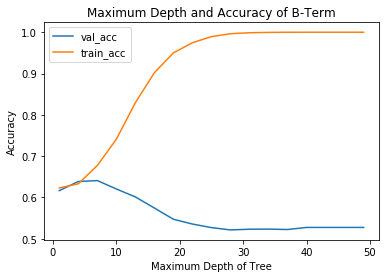

In [13]:
# visualize results
plt.plot(dt_results_b["dt__max_depth"], dt_results_b["val_acc"], label = "val_acc")
plt.plot(dt_results_b["dt__max_depth"], dt_results_b["train_acc"], label = "train_acc")
plt.xlabel("Maximum Depth of Tree")
plt.ylabel("Accuracy")
plt.title("Maximum Depth and Accuracy of B-Term")
plt.legend()
plt.show()

In [14]:
# build ranked results df
dt_results_ranked_b = dt_results_b.copy()
dt_results_ranked_b["difference"] = dt_results_b["train_acc"] - dt_results_b["val_acc"]
dt_results_ranked_b.sort_values(["difference", "val_acc"], ascending = [True, False])[:5]

,dt__max_depth,train_acc,val_acc,difference
1,4,0.632893,0.638461,-0.005568
0,1,0.622892,0.616364,0.006528
2,7,0.677232,0.640736,0.036497
3,10,0.740964,0.620394,0.120570
4,13,0.829484,0.601092,0.228392


For the B term, we can observe that our model is able to generalize better on validation data than on train data - at least in the earlier stages - which is very desirable. Because of this, I will choose the `max_depth = 4` parameter here as it has almost the same validation accuracy as `max_depth = 7`, but is better at generalizing from the train data and doesn't overfit at all.

The B-term validation accuracy is therefore 63.84%.

In [15]:
# J term
# loop through all combinations

# save results
dt_results_j = []

for param_max_depth in grid_dt:
    pipe_dt.set_params(**param_max_depth)
    
    # fit pipe
    pipe_dt.fit(X_tr_j, y_tr_j)
    
    # calculate accuracy
    val_acc = pipe_dt.score(X_val_j, y_val_j)
    train_acc = pipe_dt.score(X_tr_j, y_tr_j)
    
    # append accuracy to param_max_depth
    param_max_depth["val_acc"] = val_acc
    param_max_depth["train_acc"] = train_acc
    
    # append param_max_depth to dt_results
    dt_results_j.append(param_max_depth)
    
# transform list to DataFrame
dt_results_j = pd.DataFrame(dt_results_j)
dt_results_j.sort_values(by = "val_acc", ascending = False)[:10]

,dt__max_depth,train_acc,val_acc
2,7,0.695518,0.658940
1,4,0.669111,0.655135
0,1,0.652890,0.649143
3,10,0.747994,0.640395
4,13,0.808974,0.623119
5,16,0.866255,0.612010
6,19,0.912838,0.595478
7,22,0.947219,0.579120
8,25,0.968453,0.576452
9,28,0.982369,0.562806


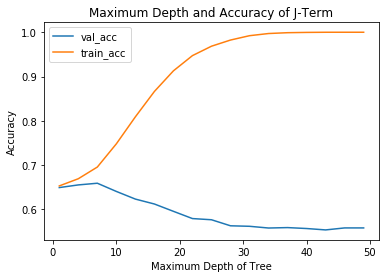

In [16]:
# visualize results
plt.plot(dt_results_j["dt__max_depth"], dt_results_j["val_acc"], label = "val_acc")
plt.plot(dt_results_j["dt__max_depth"], dt_results_j["train_acc"], label = "train_acc")
plt.xlabel("Maximum Depth of Tree")
plt.ylabel("Accuracy")
plt.title("Maximum Depth and Accuracy of J-Term")
plt.legend()
plt.show()

In [17]:
# build ranked results df
dt_results_ranked_j = dt_results_j.copy()
dt_results_ranked_j["difference"] = dt_results_j["train_acc"] - dt_results_j["val_acc"]
dt_results_ranked_j.sort_values(["difference", "val_acc"], ascending = [True, False])[:5]

,dt__max_depth,train_acc,val_acc,difference
0,1,0.652890,0.649143,0.003747
1,4,0.669111,0.655135,0.013977
2,7,0.695518,0.658940,0.036578
3,10,0.747994,0.640395,0.107599
4,13,0.808974,0.623119,0.185855


We can see here that the model slightly overfits even at `max_depth = 1`. In this case here, I will also take `max_depth = 4` due to almost the same validation accuracy as `max_depth = 7` but with only 1.4% overfitting instead of 3.7%.

We will now create the 3 pipelines with optimized maximum depth parameter and evaluate on the actual test set.

In [18]:
# build final 3 tuned models

# combined model
dt = Pipeline([
    ("scaler", MaxAbsScaler()),
    ("dt", DecisionTreeClassifier(max_depth = 4, random_state = 0))])

# fit with training data
dt.fit(X_tr, y_tr)

# get accuracy on test data
dt_acc = dt.score(X_te, y_te)
print("Combined decision tree model accuracy: {:.4f}".format(dt_acc))


# B term
dt_b = Pipeline([
    ("scaler", MaxAbsScaler()),
    ("dt", DecisionTreeClassifier(max_depth = 4, random_state = 0))])

# fit on training data
dt_b.fit(X_tr_b, y_tr_b)

# get accuracy on test data
dt_acc_b = dt_b.score(X_te_b, y_te_b)
print("B term decision tree model accuracy: {:.4f}".format(dt_acc_b))


# J term
dt_j = Pipeline([
    ("scaler", MaxAbsScaler()),
    ("dt", DecisionTreeClassifier(max_depth = 4, random_state = 0))])

# fit on training data
dt_j.fit(X_tr_j, y_tr_j)

# get accuracy on test data
dt_acc_j = dt_j.score(X_te_j, y_te_j)
print("J term decision tree model accuracy: {:.4f}".format(dt_acc_j))

Combined decision tree model accuracy: 0.6464
B term decision tree model accuracy: 0.6408
J term decision tree model accuracy: 0.6455


Our final decision tree results are:
* Combined set:
    * train: 64.10%, val: 62.85%, test: 64.64%
* B term:
    * train: 63.29%, val: 62.85%, test: 64.08%
* J term:
    * train: 66.91%, val: 65.51%, test: 64.55%
    
For the combined set, we can observe that the model is able to generalize well with no overfitting at all. Compared to the combined logistic regression model, the accuracy here is only slightly worse (logreg: 65.33, decision tree: 64.64). 

The B-term also generalizes well on our test data with no overfitting at all. We can also observe that the B-term model was now able to generalize better in two cases. In both the logistic regression and the simple decision tree model, we have a higher test accuracy than train accuracy. Nevertheless, the decision tree accuracy is around 2.5 percentage points lower than the logistic regression.

The separate J term model seems to overfit easily in both the logistic regression and the decision tree model with both models overfitting ~2.5 percentage points. Futhermore, the decision tree model also performs slightly worse with only 64.55% accuracy instead of 65.27%.

In general, the decision tree models perform worse than the logistic regression, but only marginally. Nevertheless, all model still perform at around 5-6 percentage points better than the most-frequent baseline.

In the following, I will explore and evaluate the model results more deeply with the confusion matrix and classification report.

In [19]:
from sklearn.metrics import confusion_matrix

# get predictions in array
dt_preds = dt.predict(X_te)

# create confusion matrix
dt_matrix = confusion_matrix(y_true = y_te, y_pred = dt_preds)

# convert matrix to DataFrame
dt_matrix_df = pd.DataFrame(data = dt_matrix, columns = ["pred: Fail", "pred: Withdrawn",
                                                                "pred: Pass", "pred: Distinction"],
                               index = ["true: Fail", "true: Withdrawn", "true: Pass", "true: Distinction"])
dt_matrix_df

,pred: Fail,pred: Withdrawn,pred: Pass,pred: Distinction
true: Fail,536,26,5248,39
true: Withdrawn,16,1072,4505,888
true: Pass,312,105,23458,250
true: Distinction,37,1004,2202,1680


In [20]:
from sklearn.metrics import classification_report

# print classification report to see recall and precision scores
dt_report = classification_report(y_true = y_te, y_pred = dt_preds)
print(dt_report)

              precision    recall  f1-score   support

           0       0.59      0.09      0.16      5849
           1       0.49      0.17      0.25      6481
           2       0.66      0.97      0.79     24125
           3       0.59      0.34      0.43      4923

   micro avg       0.65      0.65      0.65     41378
   macro avg       0.58      0.39      0.41     41378
weighted avg       0.62      0.65      0.57     41378



The confusion matrix shows that this estimator is also heavily biased in favor of `Pass`, even marginally more so than the logistic regression model. We now reach a recall of 97% for class `2`, which is 2 percentage points more than the logistic regression result. However, all other recall scores except `Fail` dropped, while `Fail` stayed the same at 9%. We predict class `1` 17% of times when it is, in fact, class `1`. This metric dropped from 25% in the logistic regression model. The recall score for `Distinction` also dropped from 40% to now 34%. This shows us that we increasingly predicted other classes when the true class is `1`. 

For class `Pass`, the recall score of 97% also isn't as useful in the overall model when we consider the precision score, which explains how many times we are correct when class `Pass` is predicted, is only at 66%. This describes the problem that while we almost always predict `Pass`, it is only correct in 66% of cases, which again highlights the bias in our model. 

#### Main problem of the model
Like in the logistic regression case, the recall score of 9% for class `Fail` creates an immense problem for students who want their chances accurately assessed. It is far worse to predict `Pass` when the student is likely to fail than in the other case, e.g. predicting `Withdrawn` when the student will `Pass`. The firstly described problem is the case of a false negative prediction in which positive = Fail and negative = Pass. The student would actually fail but we predict him to pass, which can create a false sense of security in the student. 

The ROC-curve will again visualize the problem of the classification between `Pass` and `Fail` in a simplified binary setting.

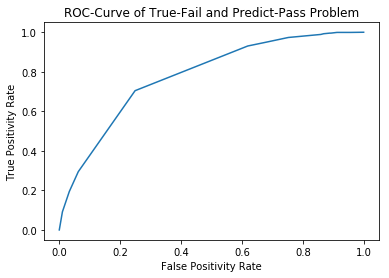

In [21]:
from sklearn.metrics import roc_curve

# get all probabilities into one variable
dt_probs = dt.predict_proba(X_te)

# roc_curve returns three arrays, false positivity rate, true positivity rate (recall) and thresholds
fpr, tpr, thresholds = roc_curve(y_true = y_te, y_score = dt_probs[:, 0], # positive class = Fail / 0
                                pos_label = 0) 

# create DataFrame out of the three arrays
roc_df = pd.DataFrame({
    "fpr": fpr,
    "tpr": tpr,
    "thresholds": thresholds
})

# plot ROC curve 
plt.plot(fpr, tpr)
plt.xlabel("False Positivity Rate")
plt.ylabel("True Positivity Rate")
plt.title("ROC-Curve of True-Fail and Predict-Pass Problem")
plt.show()

We can observe here visually that the curve is similar to the logistic regression model but still flatter, which shows us the growing prediction bias. It shows that the TPR, or recall, is even lower here and only rises when the false positivity rate also increases. 

A good model with a high recall would have a curve towards the top left corner, which would result from having a high TPR with a low FPR at the same time. 

Let's see to what level we had to lower our threshold to receive at least 85% recall.

In [22]:
roc_df

,fpr,tpr,thresholds
0,0.000000,0.000000,1.612717
1,0.010273,0.091640,0.612717
2,0.032846,0.194050,0.438124
3,0.062372,0.294580,0.310058
4,0.249036,0.704394,0.270420
5,0.619184,0.930415,0.100801
6,0.678741,0.949393,0.060764
7,0.752428,0.973500,0.058719
8,0.859298,0.988887,0.023665
9,0.868614,0.992477,0.023599


In this model, the difference between threshold changes and the effect on the TPR and FPR is very significant, which is also visible in the slope of the curve above. 

When the threshold changes from 43% to 10%, the TPR changes from 19% to 93%. The get to 85% recall we therefore have to set the threshold to around ~20%. 

It is important to keep in mind that this is just a theoretical example that simplisticly created a binary problem out of a multi-class classification. In multi-clas problems, the final prediction is constantly affected by all other probability values. Changing the threshold here to ~20% for the `Fail` class and thus classifying everything as `0` as soon as the probability hit that threshold would negatively affect all other classifications, so this is not a viable change on its own. 

All in all, this model got marginally more biased in favor of the `Pass` class than the logistic regression case. While we do reach 97% recall for class `Pass`, this doesn't help us in accurately determining final outcomes for students. The precision score for class `Pass` of 66% proves that. The decision tree model is therefore still better than our baseline but worse than the logistic regression model.

### Visualization of Decision Tree
Now we will visualize the decision tree for the combined model with `max_depth = 4` to see where the most important feature splits have taken place.

In [23]:
# load column names

with np.load(
    "/Users/Ingo/Python Files/Capstone Project/preprocessed_dfs/column_names_cleaned.npz") as npz_file:
    column_names_cleaned = list(npz_file["features"])

In [24]:
# recreate combined model without pipeline
dt_ = DecisionTreeClassifier(max_depth = 4, random_state = 0)

# fit with training data
dt_.fit(X_tr_scaled, y_tr);

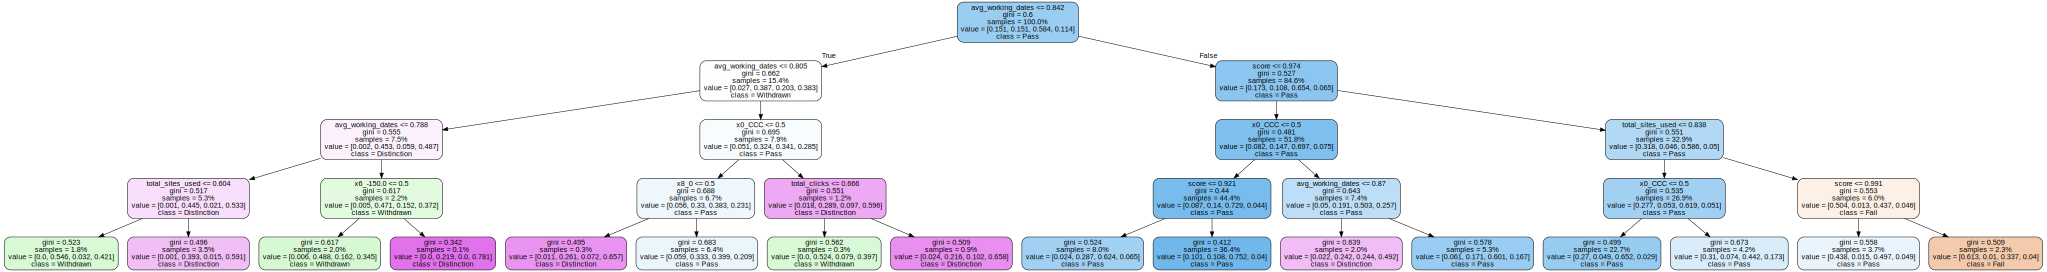

In [25]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(dt_, # tree to export, i.e. combined model with max_depth = 4, acc = 64.64%
                          out_file = None, # do not create file
                           # class names should be in ascending order according to sklearn
                          class_names = ["Fail", "Withdrawn", "Pass", "Distinction"],
                          feature_names = column_names_cleaned,
                          filled = True, rounded = True,
                          proportion = True # include proportion of each class in graph
                          )

graphviz.Source(dot_data)

We can see that the decision tree algorithm chose to split at one of the engineered features at first: It seems to be most important to split at `avg_working_dates <= 0.842` or `avg_working_dates > 0.842`.

On the second level, we either split again at the Truth arm `avg_working_dates <= 0.805`. On the False side, i.e. `avg_working_dates > 0.842`, we split at the `score` feature. 

On the following third level, other important features at which splits have taken place are: module `CCC`, `total_sites_used`, and again `avg_working_dates`.

On the fourth level, `total_sites_used`, `score` and `avg_working_dates` are again important, but also `date_registratation <= 150`, the `is_banked = No` status, and the `total_clicks` feature. 

Example of how to get classified as finishing with `Distinction`:
* Have `avg_working_dates` of less than or equal to 0.788
* Have a `date_registration` of earlier than 150 days

At this split, there is a Gini Impurity of 0.617, so there is a lot of impurity left. This also shows that we have a big challenge with nuanced classifications: The two probable opportunities for this student are either `Distinction` with only 0.1% of samples and a gini impurity of 0.342, or a rather opposite class of having `Withdrawn` with 2% samples and a gini impurity of 0.617 The values for `Withdrawing` outweigh all other classes here with a weight of 0.471. However, 0.372 are also classified as finishing with `Distinction`. 

This suggests that models have a hard time of correctly assessing when a student will withdraw. 

#### Scree plot to find influential features
To create an effective scree plot, we have to create a PCA model while not reducing the number of components. By not reducing the number, we can see how many components explain x% of the variance - up until 100%. Because PCA is again trying to center the data, we can't use sparse matrices with PCA. An alternative would be to use sklearn's [truncated singular value decomposition](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) `TruncatedSVD`, which is specifically made to use in cases of sparse matrices. However, `TruncatedSVD` doesn't support `n_components = None`, so we have to create a dense matrix and still use `PCA`. 

In [26]:
# reverse sparse matrix to array, _ns --> nosparse
X_tr_scaled_ns = X_tr_scaled.toarray()

# scree plot of combined model
from sklearn.decomposition import PCA

# create PCA object
pca = PCA(n_components = None, random_state = 0)

# fit and transform training data
X_tr_decomp = pca.fit_transform(X_tr_scaled_ns) # use separately scaled train matrix

# sum of all explained variances of a model should be equal to 1
scree_sum = sum(pca.explained_variance_ratio_)
print("sum of all pca should be equal to 1 -- check: {:.3f}".format(scree_sum))

sum of all pca should be equal to 1 -- check: 1.000


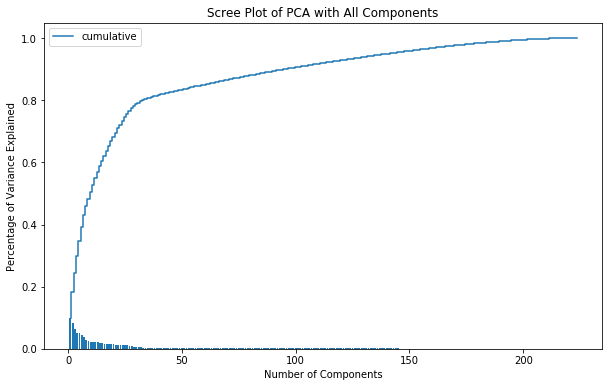

In [27]:
# get variance explained in separate variable
variance_explained = pca.explained_variance_ratio_


plt.figure(figsize = (10, 6))
# plot expalined variance as bar charts
# define x-coordinates
x_cor = np.arange(1, len(variance_explained) + 1) # start coordinates at 1 until len() + 1
plt.bar(x_cor, variance_explained)


# add cumulate variance explained
cum_var_explained = np.cumsum(variance_explained)
plt.step(x_cor + 0.5, cum_var_explained, label = "cumulative")

plt.legend()
plt.xlabel("Number of Components")
plt.ylabel("Percentage of Variance Explained")
plt.title("Scree Plot of PCA with All Components")
plt.show()

As we can see here, to get to 100% variance explained, we need all 223 components. The result is that the graph is extremely spread out and thus not very readable.

The first ~50 components seem to explain the majority of variance in the model, so let's plot them separately to get a clearer overview.

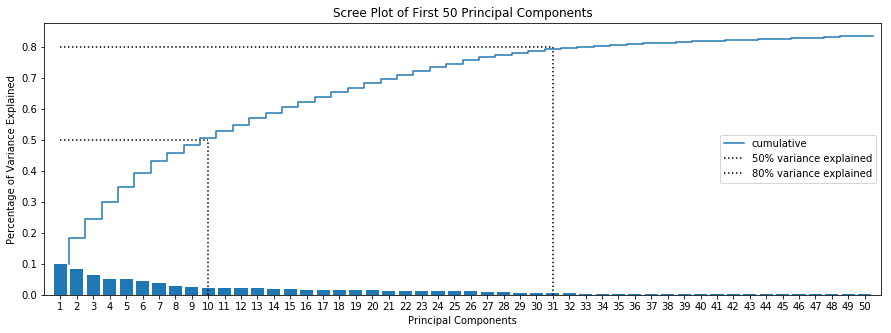

In [28]:
var_explained50 = variance_explained[:50]

plt.figure(figsize = (15, 5))
# get new xcors
x_cor50 = np.arange(1, len(var_explained50) + 1)
plt.xticks(x_cor50)
plt.xlim(left = 0, right = 51)

# plot the variance explained
plt.bar(x_cor50, var_explained50)

# get the cumulative variance explained
cum_var50 = np.cumsum(var_explained50)

# plot the steps
plt.step(x_cor50 + 0.5, cum_var50, label = "cumulative")

# plot horizontal line at 50% variance explained
plt.hlines(y = 0.5, xmin = 1, xmax = 10, color = "black", label = "50% variance explained",
          linestyles = "dotted")
plt.vlines(x = 10, ymin = 0, ymax = 0.5, color = "black", linestyles = "dotted")

# plot horizontal line at 80% variance explained
plt.hlines(y = 0.8, xmin = 1, xmax = 31, color = "black", label = "80% variance explained",
          linestyles = "dotted")
plt.vlines(x = 31, ymin = 0, ymax = 0.8, color = "black", linestyles = "dotted")

plt.title("Scree Plot of First 50 Principal Components")
plt.xlabel("Principal Components")
plt.ylabel("Percentage of Variance Explained")
plt.legend(loc = "center right")
plt.show()

We can see here clearly that the first 31 features explain around 80% of the total variance of our model. Considering that there are 223 features available, having only 31 explain 80% of all variance is remarkable. 

Furthermore, only 10 features explain 50% of all variance, which is marked with another dotted line above.

Going forward, I will now reduce down the dimensionality of our model to `n_components = 10`, and search for the best `max_depth` of all models. I will use the `TruncatedSVD` now because computation time of dense matrices with PCA takes undefined amounts of time or even gets stuck where it doesn't react to interrupting the kernel.

In [29]:
from sklearn.decomposition import TruncatedSVD

# create object
tsvd = TruncatedSVD(n_components = 10, algorithm = "arpack") # naive algorithm 

# combined term
X_tr_svd = tsvd.fit_transform(X_tr_scaled)
X_val_svd = tsvd.transform(X_val_scaled)
X_te_svd = tsvd.transform(X_te_scaled)

# B term
X_tr_svd_b = tsvd.fit_transform(X_tr_scaled_b)
X_val_svd_b = tsvd.transform(X_val_scaled_b)
X_te_svd_b = tsvd.transform(X_te_scaled_b)

# J term
X_tr_svd_j = tsvd.fit_transform(X_tr_scaled_j)
X_val_svd_j = tsvd.transform(X_val_scaled_j)
X_te_svd_j = tsvd.transform(X_te_scaled_j)

In [30]:
# fit again on combined model
tsvd.fit(X_tr_scaled)

# present results with variance in a df
tsvd_results_df = pd.DataFrame({
    "variance": X_tr_scaled_ns.var(axis = 0),
    "component 1": tsvd.components_[0],
    "component 2": tsvd.components_[1],
    "component 3": tsvd.components_[2],
    "component 4": tsvd.components_[3],
    "component 5": tsvd.components_[4],
    "component 6": tsvd.components_[5],
    "component 7": tsvd.components_[6],
    "component 8": tsvd.components_[7],
    "component 9": tsvd.components_[8],
    "component 10": tsvd.components_[9]})

tsvd_results_df.sort_values(by = "variance", ascending = False)[:10]

,variance,component 1,component 2,component 3,component 4,component 5,component 6,component 7,component 8,component 9,component 10
24,0.249843,0.162523,-0.033750,0.066409,-0.024843,-0.850335,0.336217,-0.207368,0.234545,-0.007246,-0.005315
7,0.245251,0.144335,0.455890,0.169945,-0.269875,0.037528,-0.175257,-0.471525,-0.180514,-0.099876,-0.100850
6,0.242993,0.140449,0.088045,0.156127,0.281402,0.453585,0.650355,-0.259114,0.359189,0.124188,-0.007500
20,0.228579,0.216473,0.276486,-0.619425,0.135952,-0.017686,0.069286,0.007265,-0.071356,-0.056364,-0.017694
209,0.212536,0.101715,-0.338554,-0.293646,-0.450094,0.105523,-0.030465,-0.232828,0.139784,0.420450,-0.050969
207,0.211216,0.101565,0.347035,0.199698,-0.097737,-0.071976,0.299112,0.628596,-0.206423,0.145921,-0.070648
5,0.210031,0.099604,-0.440795,-0.062105,-0.180756,0.075413,0.393856,0.019693,-0.429241,-0.370982,0.008145
21,0.208655,0.095126,-0.278160,0.606646,-0.131283,0.028982,-0.140236,0.018384,0.060103,0.065977,-0.000288
1,0.173228,0.074093,0.385320,0.168006,-0.290011,0.056843,0.041414,-0.131213,-0.008205,-0.107547,0.156575
212,0.164546,0.067585,-0.133698,0.104000,0.517687,-0.044288,-0.112765,-0.251516,-0.273622,-0.254832,0.038579


In [31]:
# get names of these 10 features
tsvd_index = tsvd_results_df.sort_values(by = "variance", ascending = False)[:10].index
np.array(column_names_cleaned)[tsvd_index]

array(['x6_-50.0', 'x2_F', 'x1_B', 'x4_0', 'x9_oucontent', 'x9_forumng',
       'x0_FFF', 'x4_1', 'x0_BBB', 'x9_subpage'], dtype='<U26')

In the above DataFrame, we have our model features as rows and the 10 components as well as the variance as columns.

We can see, for instance, that component 5 explains feature 24 (registered between 150 and 50 days in advance of presentation start) exceptionally well with a component value of -0.85. 

Additionally, component 3 explains features 20 (studies for below 60 credits) and 21 (studies between 60 and 120 credits) very well with component values of -61 and 60.

Component 2 explains feature 7 (gender = Female) really well with a component value of 0.46. Furthermore, component 2 also explains feature 5 (module `FFF`) very well with a component value of -0.44.

Negative values in this context simply mean that loading vector points in the opposite direction, so we only need to focus on values near absolute 1 to know which component explains which feature well. As the values are scaled using `MaxAbsScaler`, we eliminated the algorithmic bias for features with large variances.

We will now build 3 more models, tune them with grid search using these values with `n_components = 10`.

In [32]:
# get maximum depth for n_components = 10

# create object
test_dt_svd = DecisionTreeClassifier(criterion = "gini", max_depth = None)

# fit estimator with training data
test_dt_svd.fit(X_tr_svd, y_tr)

print("maximum possible depth of decision tree:", test_dt_svd.tree_.max_depth)

maximum possible depth of decision tree: 49


In [33]:
# create pipeline, values are already scaled
pipe_dt_svd = Pipeline([
    ("dt", DecisionTreeClassifier(criterion = "gini", random_state = 0))])

# create grid with max_depth parameters to test
grid_dt_svd = ParameterGrid({
    "dt__max_depth": np.arange(1, 50, 3)}) # 1 to 50 in steps of 3, ends therefore at 49

# get length of grid
print("length of max_depth parameters to test:", len(grid_dt_svd))

length of max_depth parameters to test: 17


In [34]:
# combined model
# loop through all combinations

# save results
dt_results_svd = []

for param_max_depth in grid_dt_svd:
    pipe_dt_svd.set_params(**param_max_depth)
    
    # fit pipe
    pipe_dt_svd.fit(X_tr_svd, y_tr)
    
    # calculate accuracy
    val_acc = pipe_dt_svd.score(X_val_svd, y_val)
    train_acc = pipe_dt_svd.score(X_tr_svd, y_tr)
    
    # append accuracy to param_max_depth
    param_max_depth["val_acc"] = val_acc
    param_max_depth["train_acc"] = train_acc
    
    # append param_max_depth to dt_results
    dt_results_svd.append(param_max_depth)
    
# transform list to DataFrame
dt_results_svd = pd.DataFrame(dt_results_svd)
dt_results_svd.sort_values(by = "val_acc", ascending = False)[:10]

,dt__max_depth,train_acc,val_acc
1,4,0.587210,0.564407
2,7,0.605154,0.563852
0,1,0.584393,0.562766
3,10,0.655020,0.539253
4,13,0.726082,0.513591
5,16,0.803577,0.494906
6,19,0.868935,0.474918
7,22,0.922027,0.456643
8,25,0.958488,0.445128
9,28,0.978440,0.434217


As we can already see in these 10 values, train accuracy reaches ~99% with a `max_depth = 28` while validation accuracy is at 52%. Because validation accuracy is at 62% with `max_depth = 7`, accuracy actually has to drop at one point while `max_depth` increases. To really see how the accuracy changes along with `max_depth`, we need to visualize the results.

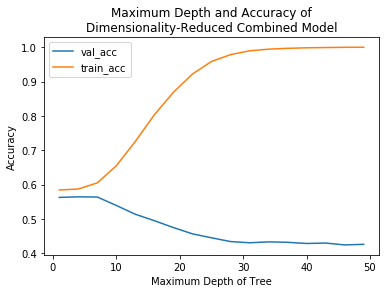

In [35]:
# visualize results
plt.plot(dt_results_svd["dt__max_depth"], dt_results_svd["val_acc"], label = "val_acc")
plt.plot(dt_results_svd["dt__max_depth"], dt_results_svd["train_acc"], label = "train_acc")
plt.xlabel("Maximum Depth of Tree")
plt.ylabel("Accuracy")
plt.title("Maximum Depth and Accuracy of\nDimensionality-Reduced Combined Model")
plt.legend()
plt.show()

We can see that overfitting is still very present at the dimensionality-reduced model, even at `max_depth = 1`. Furthermore, we start out at a lower level than in the complex model. Here, we start at with a validation accuracy of the `max_depth = 4` model of ~56%, so we have actually lost around 10 percentage point accuracy. 

The dimensionality reduction seems to have hurt the classification models in this case so badly that we are now below the naive most-frequent baseline. It seems that we need the additional information in a non-lowered dimensional space. The results suggest that our data is not structured to be decompositioned onto these limited orthogonal axes, and we thus use vital classification information.

In this case, I will take `max_depth = 4` because it has the highest validation accuracy with the least overfitting.

In this combined model, we thus reach a validation accuracy of 56.44%.

In [36]:
# B term
# loop through all combinations

# save results
dt_results_b_svd = []

for param_max_depth in grid_dt_svd:
    pipe_dt_svd.set_params(**param_max_depth)
    
    # fit pipe
    pipe_dt_svd.fit(X_tr_svd_b, y_tr_b)
    
    # calculate accuracy
    val_acc = pipe_dt_svd.score(X_val_svd_b, y_val_b)
    train_acc = pipe_dt_svd.score(X_tr_svd_b, y_tr_b)
    
    # append accuracy to param_max_depth
    param_max_depth["val_acc"] = val_acc
    param_max_depth["train_acc"] = train_acc
    
    # append param_max_depth to dt_results
    dt_results_b_svd.append(param_max_depth)
    
# transform list to DataFrame
dt_results_b_svd = pd.DataFrame(dt_results_b_svd)
dt_results_b_svd.sort_values(by = "val_acc", ascending = False)[:10]

,dt__max_depth,train_acc,val_acc
0,1,0.577695,0.577371
1,4,0.585890,0.576656
2,7,0.621176,0.561643
3,10,0.692403,0.533762
4,13,0.785935,0.507961
5,16,0.890146,0.460259
6,19,0.952952,0.445181
8,25,0.990699,0.438942
7,22,0.979320,0.438162
9,28,0.995778,0.428999


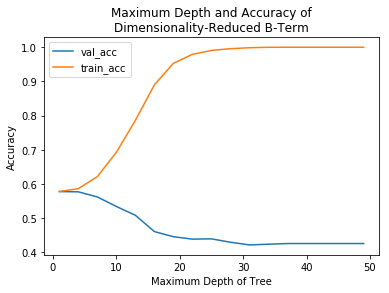

In [37]:
# visualize results
plt.plot(dt_results_b_svd["dt__max_depth"], dt_results_b_svd["val_acc"], label = "val_acc")
plt.plot(dt_results_b_svd["dt__max_depth"], dt_results_b_svd["train_acc"], label = "train_acc")
plt.xlabel("Maximum Depth of Tree")
plt.ylabel("Accuracy")
plt.title("Maximum Depth and Accuracy of\nDimensionality-Reduced B-Term")
plt.legend()
plt.show()

We can see a very similar pattern here: We lost informatinal value in the reduction and the model still overfits very easily. The accuracy of this separate B-term model is again marginally higher than for the combined model with `max_depth = 1` in this case. 

The B-term validation accuracy is therefore 57,74%.

In [38]:
# J term
# loop through all combinations

# save results
dt_results_j_svd = []

for param_max_depth in grid_dt_svd:
    pipe_dt_svd.set_params(**param_max_depth)
    
    # fit pipe
    pipe_dt_svd.fit(X_tr_svd_j, y_tr_j)
    
    # calculate accuracy
    val_acc = pipe_dt_svd.score(X_val_svd_j, y_val_j)
    train_acc = pipe_dt_svd.score(X_tr_svd_j, y_tr_j)
    
    # append accuracy to param_max_depth
    param_max_depth["val_acc"] = val_acc
    param_max_depth["train_acc"] = train_acc
    
    # append param_max_depth to dt_results
    dt_results_j_svd.append(param_max_depth)
    
# transform list to DataFrame
dt_results_j_svd = pd.DataFrame(dt_results_j_svd)
dt_results_j_svd.sort_values(by = "val_acc", ascending = False)[:10]

,dt__max_depth,train_acc,val_acc
0,1,0.625394,0.603569
1,4,0.632632,0.599983
2,7,0.654171,0.593028
3,10,0.709882,0.574309
4,13,0.775041,0.552790
5,16,0.842619,0.524099
6,19,0.895447,0.500875
7,22,0.932182,0.482418
8,25,0.961744,0.467985
9,28,0.979150,0.466279


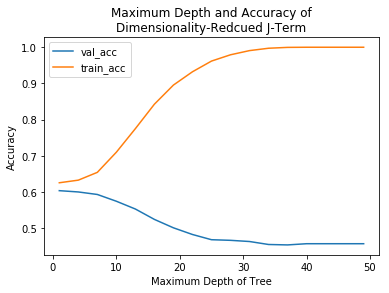

In [39]:
# visualize results
plt.plot(dt_results_j_svd["dt__max_depth"], dt_results_j_svd["val_acc"], label = "val_acc")
plt.plot(dt_results_j_svd["dt__max_depth"], dt_results_j_svd["train_acc"], label = "train_acc")
plt.xlabel("Maximum Depth of Tree")
plt.ylabel("Accuracy")
plt.title("Maximum Depth and Accuracy of\nDimensionality-Redcued J-Term")
plt.legend()
plt.show()

We can see here that the model slightly overfits with ~2 percentage points even at `max_depth = 1`. In this case here, I will also take `max_depth = 1` as going with more depth increases overfitting even more.

The validation accuracy for the J-term model is: 60.36%.

The same pattern of dimensioality reduction applies here: We lose information vital for classification during the dimensionality reduction. Although we get barely above the naive baseline here, dimensionality reduction produces worse results than the tuned default models with our features. 

We will now create the 3 pipelines with optimized maximum depth parameter and evaluate on the actual test set.

In [40]:
# build final 3 tuned models with reduced dimensinality
# matrices are already scaled, so no pipeline needed

# combined model
dt_svd = DecisionTreeClassifier(max_depth = 4, random_state = 0)

# fit with training data
dt_svd.fit(X_tr_svd, y_tr)

# get accuracy on test data
dt_acc_svd = dt_svd.score(X_te_svd, y_te)
print("Combined decision tree model accuracy: {:.4f}".format(dt_acc_svd))


# B term
dt_svd_b = DecisionTreeClassifier(max_depth = 1, random_state = 0)

# fit on training data
dt_svd_b.fit(X_tr_svd_b, y_tr_b)

# get accuracy on test data
dt_acc_svd_b = dt_svd_b.score(X_te_svd_b, y_te_b)
print("B term decision tree model accuracy: {:.4f}".format(dt_acc_svd_b))


# J term
dt_svd_j = DecisionTreeClassifier(max_depth = 1, random_state = 0)

# fit on training data
dt_svd_j.fit(X_tr_svd_j, y_tr_j)

# get accuracy on test data
dt_acc_svd_j = dt_svd_j.score(X_te_svd_j, y_te_j)
print("J term decision tree model accuracy: {:.4f}".format(dt_acc_svd_j))

Combined decision tree model accuracy: 0.5821
B term decision tree model accuracy: 0.5889
J term decision tree model accuracy: 0.5818


Our final decision tree results for the dimensionality-reduced models are:
* Combined set:
    * train: 58.72%, val: 56.44%, test: 58.21%
* B term:
    * train: 57.77%, val: 57.74%, test: 58.89%
* J term:
    * train: 62.53%, val: 60.36%, test: 58.18%
    
While the combined set overfits with only ~0.5 percentage points, the J-term model overfits with around 4 percentage points. On the other hand, the B-term model doesn't overfit at all and is able to generalize better on unseen data than on the test set.

This is a common theme we have seen, which demonstrates nicely that the combined set is a weighted average of the separate terms. The B-term, until now, always had a better generalization and the J-term a worse generalization. The combined set averages them out to very little or no overfitting.

In general, dimensionality reduction still delivers good results considering that we now only have 10 components. However, to create the most accuracte predictions we have to base our models around all features as we now just barely met the naive most-frequent baseline.

We will now check how the prediction distribution has changed.

In [41]:
# get predictions in array
dt_svd_preds = dt_svd.predict(X_te_svd)

# create confusion matrix
dt_svd_matrix = confusion_matrix(y_true = y_te, y_pred = dt_svd_preds)

# convert matrix to DataFrame
dt_svd_matrix_df = pd.DataFrame(data = dt_svd_matrix, columns = ["pred: Fail", "pred: Withdrawn",
                                                                "pred: Pass", "pred: Distinction"],
                               index = ["true: Fail", "true: Withdrawn", "true: Pass", "true: Distinction"])
dt_svd_matrix_df

,pred: Fail,pred: Withdrawn,pred: Pass,pred: Distinction
true: Fail,0,2,5817,30
true: Withdrawn,0,43,6324,114
true: Pass,0,72,23896,157
true: Distinction,0,49,4727,147


In [42]:
# print classification report to see recall and precision scores
dt_svd_report = classification_report(y_true = y_te, y_pred = dt_svd_preds)
print(dt_svd_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5849
           1       0.26      0.01      0.01      6481
           2       0.59      0.99      0.74     24125
           3       0.33      0.03      0.05      4923

   micro avg       0.58      0.58      0.58     41378
   macro avg       0.29      0.26      0.20     41378
weighted avg       0.42      0.58      0.44     41378



/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The accuracy of the `TruncatedSVD` models has dropped below the accuracy of the non-dimensionality-reduced models and this confusion matrix shows why: The rate of class `Pass` predictions has again increased, which means that the model's bias has increased. We now predict almost exclusively `Pass` and not even once `Fail`. 

As there is no prediction for class `0`, the classification report shows a warning because there are no 0-predicted labels to be found. 

The dimensionality reduction seems to have hurt the predictions in the sense of the model only recognizing `Pass` predictions. The recall score of 99% for class `Pass` shows that we indeed predict 99% of true pass cases as positive, but the precision score of 59% sets this score into context: Although the estimator almost exclusively predicts `Pass`, only 59% of those predictions are accurate. 

In our model above we had recall scores of 9%, 17%, 97%, and 34% respectively, and 3 of them have sunk to 0%, 1%, and 3% for classes `Fail`, `Withdrawn`, and `Distinction`, respectively. This highlights again how one-sided the predictions have gotten. 

#### Main problem of the model
The problem of false negatives in the context of `Fail` = positive class and `Pass` = negative class has increased here. While initially the recall of 9% was already problematic, here we don't have a single prediction for class `Fail`, which automatically results in a recall score of 0%. The consequence is a model which is close to the most-frequent baseline as we, besides the few predictions for `1` and `3`, predict `Pass` 40,764 times out of 41,378 total predictions. 

The ROC-curve will again visualize the problem of the classification between `Pass` and `Fail` in a simplified binary setting.

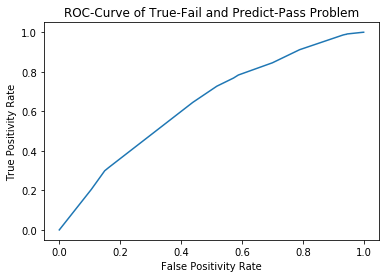

In [43]:
# get all probabilities into one variable
dt_svd_probs = dt_svd.predict_proba(X_te_svd)

# roc_curve returns three arrays, false positivity rate, true positivity rate (recall) and thresholds
fpr_svd, tpr_svd, thresholds_svd = roc_curve(y_true = y_te, y_score = dt_svd_probs[:, 0],
                                pos_label = 0) # positive class = Fail / 0

# create DataFrame out of the three arrays
roc_svd_df = pd.DataFrame({
    "fpr": fpr_svd,
    "tpr": tpr_svd,
    "thresholds": thresholds_svd
})

# plot ROC curve 
plt.plot(fpr_svd, tpr_svd)
plt.xlabel("False Positivity Rate")
plt.ylabel("True Positivity Rate")
plt.title("ROC-Curve of True-Fail and Predict-Pass Problem")
plt.show()

We can observe here visually that the curve got again flatter than in our non-dimensionality-reduced model above. This shows that the conflict between the recall rate and false positive predictions has grown even larger. A good model with a high recall would have a curve towards the top left corner, which would result from having a high TPR with a low FPR at the same time. Here, it is rather the opposite as we don't even have a single prediction for the `Fail` class. 

Let's see to what level we had to lower our threshold to receive at least 85% recall.

In [44]:
roc_svd_df

,fpr,tpr,thresholds
0,0.000000,0.000000,1.252647
1,0.105097,0.204650,0.252647
2,0.149202,0.299196,0.239356
3,0.161896,0.315097,0.185695
4,0.438656,0.645239,0.173558
5,0.517690,0.727133,0.147124
6,0.572434,0.768336,0.139388
7,0.588224,0.783553,0.107056
8,0.700217,0.845444,0.102795
9,0.789411,0.911609,0.094631


The rates also change here very significantly with little change in thresholds. For example, changing the probability threshold 18.5% to 17.3% leads to a change in TPR of 31.5% to now 64.5%.

In this instance, we would have to lower our probability threshold to around 11% to get 85% recall for the `Fail` class. 

It is important to keep in mind that this is just a theoretical example that simplisticly created a binary problem out of a multi-class classification. In multi-clas problems, the final prediction is constantly affected by all other probability values. Changing the threshold here to 11% for the `Fail` class and thus classifying everything as `0` as soon as the probability hit that threshold would negatively affect all other classifications, so this is not a viable change on its own. 

All in all, this model is so biased in favor of the `Pass` class that we don't have a single prediction for the `Fail` class. In practice, this would be detrimental to every student because the model disregards the possibility of even finishing with `Fail`.

In [45]:
# get recall scores in variables
dt_recall_0 = 0.09
dt_recall_1 = 0.17
dt_recall_2 = 0.97
dt_recall_3 = 0.34

# get recall scores of svd model in variables
dt_svd_recall_0 = 0.00
dt_svd_recall_1 = 0.01
dt_svd_recall_2 = 0.99
dt_svd_recall_3 = 0.03

# create a DataFrame to store recall scores and save the file
save_df_recall = pd.DataFrame({
    "classes": [0, 1, 2, 3],
    "recall": [dt_recall_0, dt_recall_1, dt_recall_2, dt_recall_3]})

# create a DataFrame to store svd recall scores and save the file
save_svd_df_recall = pd.DataFrame({
    "classes": [0, 1, 2, 3],
    "recall": [dt_svd_recall_0, dt_svd_recall_1, dt_svd_recall_2, dt_svd_recall_3]})

# save the df
save_df_recall.to_csv(
    "/Users/Ingo/Python Files/Capstone Project/results/04-decision-tree-recall-results.csv",
    index = False)

save_svd_df_recall.to_csv(
    "/Users/Ingo/Python Files/Capstone Project/results/04-decision-tree-svd-recall-results.csv",
    index = False)

# save roc_curve values in df
roc_df.to_csv(
    "/Users/Ingo/Python Files/Capstone Project/results/04-decision-tree-roc-results.csv",
    index = False)

roc_svd_df.to_csv(
    "/Users/Ingo/Python Files/Capstone Project/results/04-decision-tree-svd-roc-results.csv",
    index = False)

In [46]:
# create a DataFrame to store our the test accuracies and save the file
save_df = pd.DataFrame({
    "model": ["dt", "dt_b", "dt_j", "dt_svd", "dt_svd_b", "dt_svd_j"],
    "test_accuracy": [dt_acc, dt_acc_b, dt_acc_j, dt_acc_svd, dt_acc_svd_b, dt_acc_svd_j]
})

# save the df
save_df.to_csv("/Users/Ingo/Python Files/Capstone Project/results/04-decision-tree-results.csv",
              index = False)